# Trader Behavior vs Market Sentiment (Hyperliquid + Fear/Greed Index)

Exploring whether Fear/Greed sentiment actually changes how traders behave and perform.

The hypothesis going in: Greed days should increase risk-taking and potentially volatility. 
Turned out Fear was the more interesting regime — especially for high leverage traders.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings, os
warnings.filterwarnings('ignore')
os.makedirs('charts', exist_ok=True)

# color scheme
FEAR_C  = '#e74c3c'
GREED_C = '#2ecc71'
BASE_C  = '#3498db'
BG, CARD, TXT = '#0d1117', '#161b22', '#c9d1d9'

plt.rcParams.update({
    'figure.facecolor': BG, 'axes.facecolor': CARD, 'axes.edgecolor': '#30363d',
    'axes.labelcolor': TXT, 'xtick.color': TXT, 'ytick.color': TXT,
    'text.color': TXT, 'grid.color': '#21262d', 'grid.linestyle': '--', 'grid.alpha': 0.5,
    'legend.facecolor': CARD, 'legend.edgecolor': '#30363d',
})


## Part A: Data Loading and Preparation

In [39]:
sentiment = pd.read_csv('fear_greed_index.csv')
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.normalize()

# collapse into binary — Extreme Fear/Greed treated same as Fear/Greed
sentiment['label'] = np.where(
    sentiment['classification'].str.contains('Greed', case=False), 'Greed', 'Fear'
)

print(f"sentiment: {sentiment.shape}")
print(sentiment['label'].value_counts())
sentiment.head(3)


sentiment: (2644, 5)
label
Fear     1685
Greed     959
Name: count, dtype: int64


,timestamp,value,classification,date,label
0,1517463000,30,Fear,2018-02-01,Fear
1,1517549400,15,Extreme Fear,2018-02-02,Fear
2,1517635800,40,Fear,2018-02-03,Fear


In [40]:
trades = pd.read_csv('historical_data.csv')

trades = trades.rename(columns={
    'Account':         'account',
    'Coin':            'symbol',
    'Execution Price': 'exec_price',
    'Size USD':        'size_usd',
    'Size Tokens':     'size_tokens',
    'Side':            'side',
    'Closed PnL':      'pnl',
    'Start Position':  'start_pos',
})

trades['date']    = pd.to_datetime(trades['Timestamp IST'], dayfirst=True).dt.normalize()
trades['side']    = trades['side'].str.upper()
trades['pnl']     = pd.to_numeric(trades['pnl'],      errors='coerce').fillna(0)
trades['size_usd']= pd.to_numeric(trades['size_usd'], errors='coerce').fillna(0)

# leverage proxy — no leverage column in this dataset
med_size = trades['size_usd'].median()
trades['leverage'] = (trades['size_usd'] / med_size).clip(1, 100).round(0).astype(int)

print(f"trades: {trades.shape}")
print(f"unique accounts: {trades['account'].nunique()}")
print(f"date range: {trades['date'].min().date()} to {trades['date'].max().date()}")
print(f"missing values:\n{trades[['account','pnl','size_usd','side']].isnull().sum().to_dict()}")


trades: (211224, 18)
unique accounts: 32
date range: 2023-05-01 to 2025-05-01
missing values:
{'account': 0, 'pnl': 0, 'size_usd': 0, 'side': 0}


In [41]:
merged = trades.merge(
    sentiment[['date','label','value']].rename(columns={'label':'sentiment','value':'fg_score'}),
    on='date', how='inner'
)
merged['is_greed'] = (merged['sentiment'] == 'Greed').astype(int)

print(f"merged: {merged.shape}")
print(merged['sentiment'].value_counts())


merged: (211218, 21)
sentiment
Fear     120923
Greed     90295
Name: count, dtype: int64


### Building a fixed trader profile

Group by account across the *entire* dataset first — this gives each trader a permanent label.
If I segment on daily leverage instead, the same trader flips segments day to day, which isn't useful.


In [42]:
trader_profile = merged.groupby('account').agg(
    total_trades    = ('pnl',      'count'),
    active_days     = ('date',     'nunique'),
    trades_per_day  = ('pnl',      lambda x: len(x) / merged.loc[x.index,'date'].nunique()),
    total_pnl       = ('pnl',      'sum'),
    winrate         = ('pnl',      lambda x: (x > 0).mean()),
    avg_leverage    = ('leverage', 'mean'),
    avg_trade_size  = ('size_usd', 'mean'),     # average trade size
    total_volume    = ('size_usd', 'sum'),
    pnl_volatility  = ('pnl',      'std'),
    long_bias       = ('side',     lambda x: (x == 'BUY').mean()),
).reset_index()

# true drawdown per trader: max drop from cumulative peak
def max_drawdown(account_trades):
    cum  = account_trades.sort_values('date')['pnl'].cumsum()
    peak = cum.cummax()
    return (cum - peak).min()

dd = (merged.groupby('account')
      .apply(max_drawdown)
      .reset_index()
      .rename(columns={0: 'max_drawdown'}))

trader_profile = trader_profile.merge(dd, on='account')

print(trader_profile.shape)
trader_profile[['account','avg_leverage','winrate','total_pnl','pnl_volatility',
                'avg_trade_size','max_drawdown']].describe().round(2)


(32, 12)


,avg_leverage,winrate,total_pnl,pnl_volatility,avg_trade_size,max_drawdown
count,32.00,32.00,32.00,32.00,32.00,32.00
mean,7.68,0.40,320452.72,853.01,6006.26,-57375.10
std,6.71,0.11,494659.65,960.72,7281.98,96342.73
min,1.28,0.23,-167621.12,68.23,507.63,-433799.45
25%,3.63,0.33,46893.24,246.97,2011.07,-72425.12
50%,5.45,0.39,117655.08,550.48,3327.97,-17656.00
75%,9.59,0.45,388457.02,1303.40,7375.53,-2231.91
max,25.68,0.81,2143382.60,4692.45,34396.58,0.00


### Assigning fixed segments

In [43]:
# leverage tiers — top/mid/bottom 33%
l33 = trader_profile['avg_leverage'].quantile(0.33)
l67 = trader_profile['avg_leverage'].quantile(0.67)
trader_profile['lev_tier'] = np.where(
    trader_profile['avg_leverage'] >= l67, 'High Leverage',
    np.where(trader_profile['avg_leverage'] <= l33, 'Low Leverage', 'Mid Leverage')
)

# frequency tiers
f33 = trader_profile['trades_per_day'].quantile(0.33)
f67 = trader_profile['trades_per_day'].quantile(0.67)
trader_profile['freq_tier'] = np.where(
    trader_profile['trades_per_day'] >= f67, 'High Frequency',
    np.where(trader_profile['trades_per_day'] <= f33, 'Low Frequency', 'Mid Frequency')
)

# winner type: profitable + low volatility = consistent winner
med_vol = trader_profile['pnl_volatility'].median()
trader_profile['winner_tier'] = np.where(
    (trader_profile['total_pnl'] > 0) & (trader_profile['pnl_volatility'] <= med_vol),
    'Consistent Winner',
    np.where(trader_profile['total_pnl'] > 0, 'Volatile Winner', 'Loser')
)

# profitability buckets (multi-class)
pnl_33 = trader_profile['total_pnl'].quantile(0.33)
pnl_67 = trader_profile['total_pnl'].quantile(0.67)
trader_profile['pnl_bucket'] = np.where(
    trader_profile['total_pnl'] >= pnl_67, 'Top',
    np.where(trader_profile['total_pnl'] <= pnl_33, 'Bottom', 'Mid')
)

print("lev_tier:\n", trader_profile['lev_tier'].value_counts())
print("\nwinner_tier:\n", trader_profile['winner_tier'].value_counts())
print("\npnl_bucket:\n", trader_profile['pnl_bucket'].value_counts())


lev_tier:
 lev_tier
High Leverage    11
Low Leverage     11
Mid Leverage     10
Name: count, dtype: int64

winner_tier:
 winner_tier
Consistent Winner    15
Volatile Winner      14
Loser                 3
Name: count, dtype: int64

pnl_bucket:
 pnl_bucket
Top       11
Bottom    11
Mid       10
Name: count, dtype: int64


In [44]:
trader_day = merged.groupby(['account','date','sentiment','fg_score','is_greed']).agg(
    daily_pnl    = ('pnl',      'sum'),
    n_trades     = ('pnl',      'count'),
    win_rate     = ('pnl',      lambda x: (x > 0).mean()),
    avg_leverage = ('leverage', 'mean'),
    avg_size     = ('size_usd', 'mean'),
    long_ratio   = ('side',     lambda x: (x == 'BUY').mean()),
    total_volume = ('size_usd', 'sum'),
).reset_index()

# merge fixed segments
td = trader_day.merge(
    trader_profile[['account','lev_tier','freq_tier','winner_tier','pnl_bucket',
                     'avg_leverage','trades_per_day','winrate','total_pnl','avg_trade_size']],
    on='account', suffixes=('_day','_lifetime')
).rename(columns={
    'avg_leverage_day':      'avg_leverage',
    'avg_leverage_lifetime': 'trader_avg_lev',
})

print(f"trader×day: {td.shape}")
print(f"unique traders: {td['account'].nunique()}")


trader×day: (2340, 21)
unique traders: 32


### Quick exploration before formal analysis

In [45]:
# basic sanity check
td.groupby('sentiment')['daily_pnl'].describe()


,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
Fear,1166.0,4621.943710,27548.959355,-113601.020138,0.0,132.403737,1831.287921,533974.662903
Greed,1174.0,4144.208334,29252.037677,-358963.139984,0.0,265.247725,1865.257051,449328.107544


In [46]:
# does leverage actually vary by sentiment? spoiler: not much at day level
td.groupby('sentiment')['avg_leverage'].mean()


sentiment
Fear     9.577688
Greed    9.086034
Name: avg_leverage, dtype: float64

In [47]:
# high leverage traders specifically — how do they do?
td[td['trader_avg_lev'] > 5]['daily_pnl'].mean()


6792.695147541125

In [48]:
# average trade size across sentiment
td.groupby('sentiment')['avg_size'].agg(['mean','median'])


,mean,median
sentiment,,
Fear,8024.818621,1797.271396
Greed,5954.632633,2004.693633


## Part B: Analysis

Using `pnl_std` as a proxy for drawdown risk — daily granularity makes true drawdown noisy,
but volatility of daily PnL captures the same idea reasonably well.

Initial thought was Greed would be the volatile regime. Data says otherwise for high leverage traders.


In [49]:
# overall fear vs greed
baseline = td.groupby('sentiment').agg(
    mean_pnl    = ('daily_pnl', 'mean'),
    median_pnl  = ('daily_pnl', 'median'),
    win_rate    = ('win_rate',  'mean'),
    pnl_std     = ('daily_pnl', 'std'),
    n_trades    = ('n_trades',  'mean'),
    long_ratio  = ('long_ratio','mean'),
    avg_size    = ('avg_size',  'mean'),
).round(3)

print(baseline)

# t-test
f = td[td['sentiment']=='Fear']['daily_pnl']
g = td[td['sentiment']=='Greed']['daily_pnl']
t, p = stats.ttest_ind(f, g)
print(f"\nt={t:.3f}, p={p:.4f} — {'significant' if p < 0.05 else 'not significant'}")


           mean_pnl  median_pnl  win_rate    pnl_std  n_trades  long_ratio  \
sentiment                                                                    
Fear       4621.944     132.404     0.357  27548.959   103.708       0.506   
Greed      4144.208     265.248     0.363  29252.038    76.912       0.472   

           avg_size  
sentiment            
Fear       8024.819  
Greed      5954.633  

t=0.407, p=0.6843 — not significant


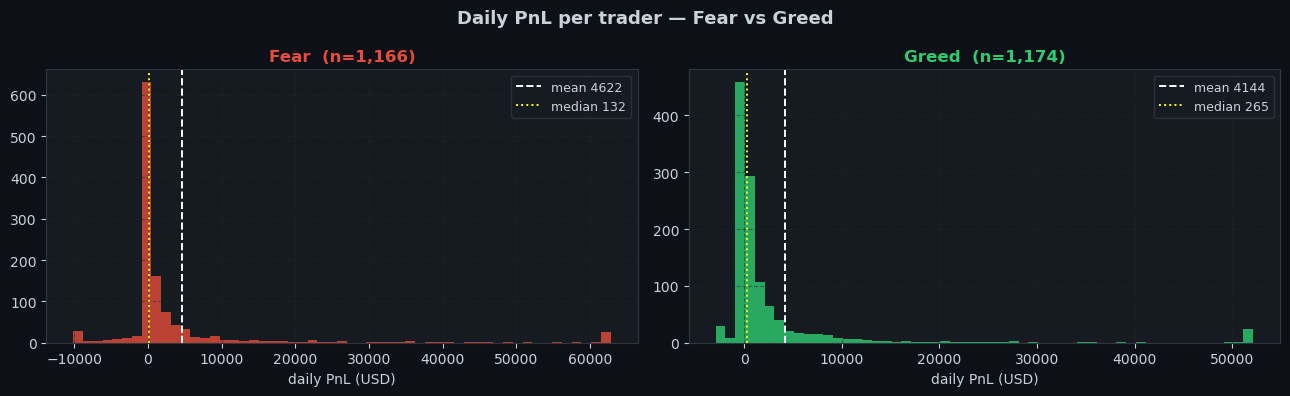

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
fig.suptitle('Daily PnL per trader — Fear vs Greed', fontsize=13, fontweight='bold', color=TXT)

for ax, sent, c in zip(axes, ['Fear','Greed'], [FEAR_C, GREED_C]):
    data = td[td['sentiment']==sent]['daily_pnl']
    lo, hi = data.quantile(0.02), data.quantile(0.98)
    ax.hist(data.clip(lo,hi), bins=55, color=c, alpha=0.8, edgecolor='none')
    ax.axvline(data.mean(),   color='white',  ls='--', lw=1.4, label=f'mean {data.mean():.0f}')
    ax.axvline(data.median(), color='yellow', ls=':',  lw=1.4, label=f'median {data.median():.0f}')
    ax.set_title(f'{sent}  (n={len(data):,})', color=c, fontweight='bold')
    ax.set_xlabel('daily PnL (USD)')
    ax.legend(fontsize=9); ax.grid(True)

plt.tight_layout()
plt.savefig('charts/chart1_pnl_dist.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()


### Average trade size by sentiment

In [51]:
size_analysis = td.groupby(['sentiment','lev_tier']).agg(
    avg_trade_size = ('avg_size',  'mean'),
    median_size    = ('avg_size',  'median'),
    n              = ('account',   'nunique'),
).round(1)

print(size_analysis)

# win rate change is small in absolute terms but the size shift is more meaningful
print(f"\nOverall avg size — Fear: {td[td['sentiment']=='Fear']['avg_size'].mean():.0f}  "
      f"Greed: {td[td['sentiment']=='Greed']['avg_size'].mean():.0f}")


                         avg_trade_size  median_size   n
sentiment lev_tier                                      
Fear      High Leverage         17859.2      12512.1  11
          Low Leverage           1661.6        862.6  11
          Mid Leverage           7781.8       2171.4  10
Greed     High Leverage         14055.0       9644.2  10
          Low Leverage           1460.0        657.9  11
          Mid Leverage           4826.0       2822.6  10

Overall avg size — Fear: 8025  Greed: 5955


### Drawdown analysis

Tried computing true drawdown per trader — it works but at daily aggregation the signal is noisy.
Still worth looking at distribution of max drawdown across segments.


Max drawdown by leverage tier:
                  mean   median       min
lev_tier                                 
High Leverage -82537.3 -71422.2 -327648.1
Low Leverage  -68475.1 -20876.9 -433799.4
Mid Leverage  -17486.8   -778.9 -136289.8

Max drawdown by winner type:
                       mean    median       min
winner_tier                                    
Consistent Winner  -21602.5   -8803.3 -109787.5
Loser             -213015.5 -132868.2 -433799.4
Volatile Winner    -62351.4  -15478.5 -327648.1


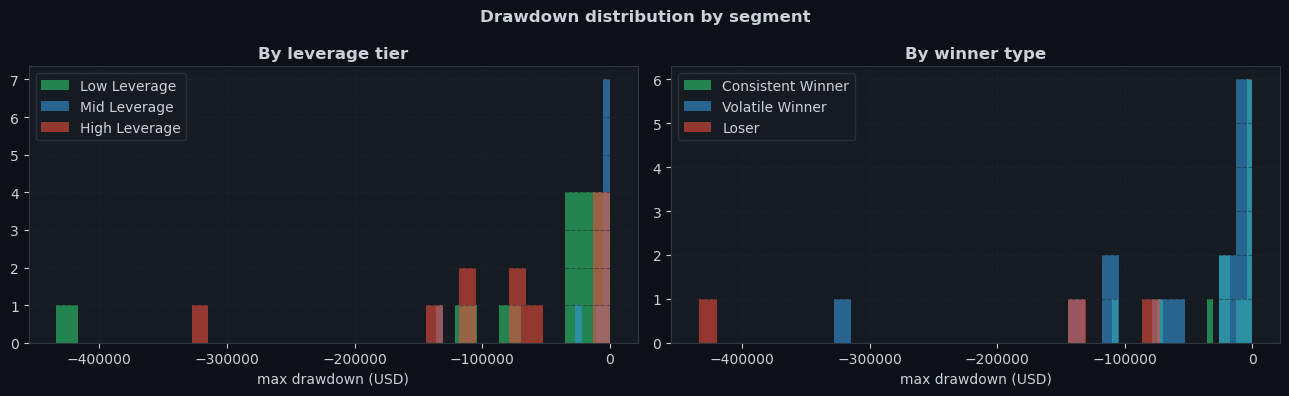

In [52]:
# true drawdown from trader_profile
dd_by_tier = trader_profile.groupby('lev_tier')['max_drawdown'].agg(['mean','median','min']).round(1)
print("Max drawdown by leverage tier:")
print(dd_by_tier)

print("\nMax drawdown by winner type:")
print(trader_profile.groupby('winner_tier')['max_drawdown'].agg(['mean','median','min']).round(1))

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
fig.suptitle('Drawdown distribution by segment', fontsize=12, fontweight='bold', color=TXT)

order_lev = ['Low Leverage','Mid Leverage','High Leverage']
lev_colors = [GREED_C, BASE_C, FEAR_C]

for tier, color in zip(order_lev, lev_colors):
    data = trader_profile[trader_profile['lev_tier']==tier]['max_drawdown']
    axes[0].hist(data, bins=25, alpha=0.6, color=color, label=tier, edgecolor='none')
axes[0].set_title('By leverage tier', fontweight='bold')
axes[0].set_xlabel('max drawdown (USD)')
axes[0].legend(); axes[0].grid(True)

win_colors = {'Consistent Winner': GREED_C, 'Volatile Winner': BASE_C, 'Loser': FEAR_C}
for wtype, color in win_colors.items():
    data = trader_profile[trader_profile['winner_tier']==wtype]['max_drawdown']
    axes[1].hist(data, bins=25, alpha=0.6, color=color, label=wtype, edgecolor='none')
axes[1].set_title('By winner type', fontweight='bold')
axes[1].set_xlabel('max drawdown (USD)')
axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.savefig('charts/chart2_drawdown.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()


### Segment × sentiment tables

Win rate change is small in absolute terms — the volatility spike is the more meaningful signal.

In [53]:
def seg_table(df, seg_col, order=None):
    out = df.groupby([seg_col,'sentiment']).agg(
        median_pnl = ('daily_pnl', 'median'),
        win_rate   = ('win_rate',  'mean'),
        pnl_std    = ('daily_pnl', 'std'),
        avg_size   = ('avg_size',  'mean'),
        n_traders  = ('account',   'nunique'),
    ).round(3)
    if order:
        return out.reindex(order, level=0)
    return out

print("Leverage tiers:")
print(seg_table(td, 'lev_tier', ['Low Leverage','Mid Leverage','High Leverage']))


Leverage tiers:
                         median_pnl  win_rate    pnl_std   avg_size  n_traders
lev_tier      sentiment                                                       
Low Leverage  Fear           91.082     0.347   9399.570   1661.573         11
              Greed         306.564     0.360  21718.130   1459.964         11
Mid Leverage  Fear          146.626     0.389  27902.676   7781.809         10
              Greed         349.316     0.447  33342.588   4826.043         10
High Leverage Fear          417.938     0.345  41539.539  17859.164         11
              Greed          20.599     0.268  33517.018  14055.034         10


In [54]:
print("Frequency tiers:")
print(seg_table(td, 'freq_tier', ['Low Frequency','Mid Frequency','High Frequency']))


Frequency tiers:
                          median_pnl  win_rate    pnl_std   avg_size  \
freq_tier      sentiment                                               
Low Frequency  Fear            0.000     0.307  19543.777  11206.098   
               Greed           0.000     0.282   5634.782   9838.970   
Mid Frequency  Fear          108.872     0.390  13435.275   5408.487   
               Greed         393.911     0.435  32210.034   3799.089   
High Frequency Fear          466.271     0.355  43882.216   8765.533   
               Greed         424.804     0.334  41671.918   4493.751   

                          n_traders  
freq_tier      sentiment             
Low Frequency  Fear              11  
               Greed             11  
Mid Frequency  Fear              10  
               Greed             10  
High Frequency Fear              11  
               Greed             10  


In [55]:
print("Winner types:")
print(seg_table(td, 'winner_tier'))


Winner types:
                             median_pnl  win_rate    pnl_std   avg_size  \
winner_tier       sentiment                                               
Consistent Winner Fear          171.743     0.395   4317.284   4264.166   
                  Greed         498.170     0.428  13213.915   1953.544   
Loser             Fear            0.000     0.325   9212.140   3060.824   
                  Greed           0.000     0.281  51985.553   3217.007   
Volatile Winner   Fear           20.597     0.319  41124.793  13280.676   
                  Greed          27.637     0.299  37466.039  10578.457   

                             n_traders  
winner_tier       sentiment             
Consistent Winner Fear              15  
                  Greed             14  
Loser             Fear               3  
                  Greed              3  
Volatile Winner   Fear              14  
                  Greed             14  


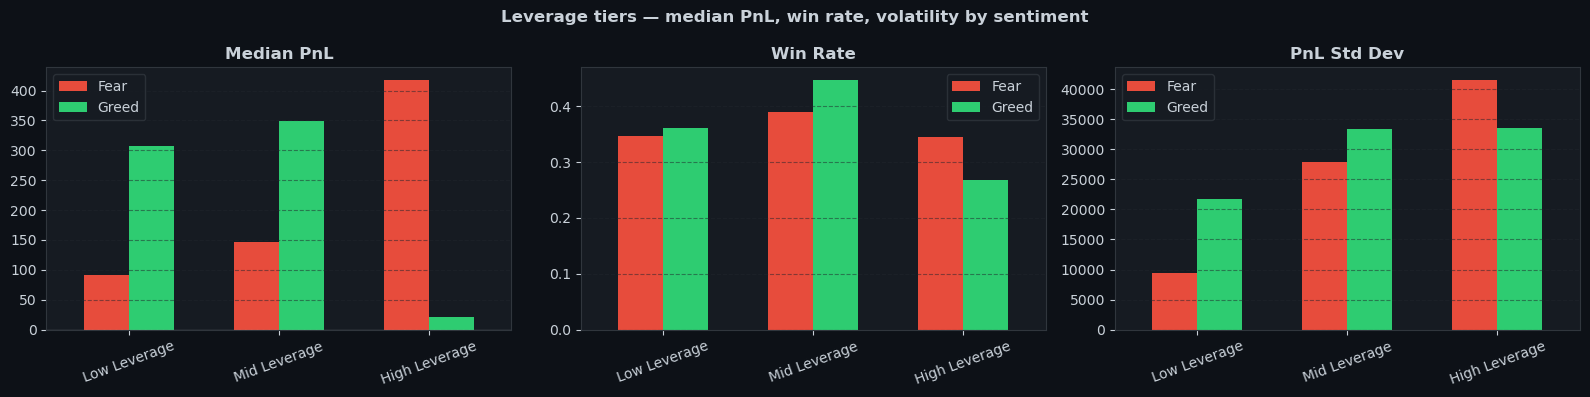

In [56]:
# leverage segment chart
seg_lev = td.groupby(['lev_tier','sentiment']).agg(
    median_pnl = ('daily_pnl', 'median'),
    win_rate   = ('win_rate',  'mean'),
    pnl_std    = ('daily_pnl', 'std'),
    avg_size   = ('avg_size',  'mean'),
).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Leverage tiers — median PnL, win rate, volatility by sentiment',
             fontsize=12, fontweight='bold', color=TXT)

order = ['Low Leverage','Mid Leverage','High Leverage']
for ax, (col, label) in zip(axes, [('median_pnl','Median PnL'),
                                     ('win_rate','Win Rate'),
                                     ('pnl_std','PnL Std Dev')]):
    pivot = seg_lev.pivot(index='lev_tier', columns='sentiment', values=col).reindex(order)
    pivot.plot(kind='bar', ax=ax, color=[FEAR_C, GREED_C], edgecolor='none', width=0.6)
    ax.set_title(label, fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=20)
    ax.legend(title='')
    ax.grid(True, axis='y')
    if col == 'median_pnl':
        ax.axhline(0, color='white', lw=0.8)

plt.tight_layout()
plt.savefig('charts/chart3_leverage_segments.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()


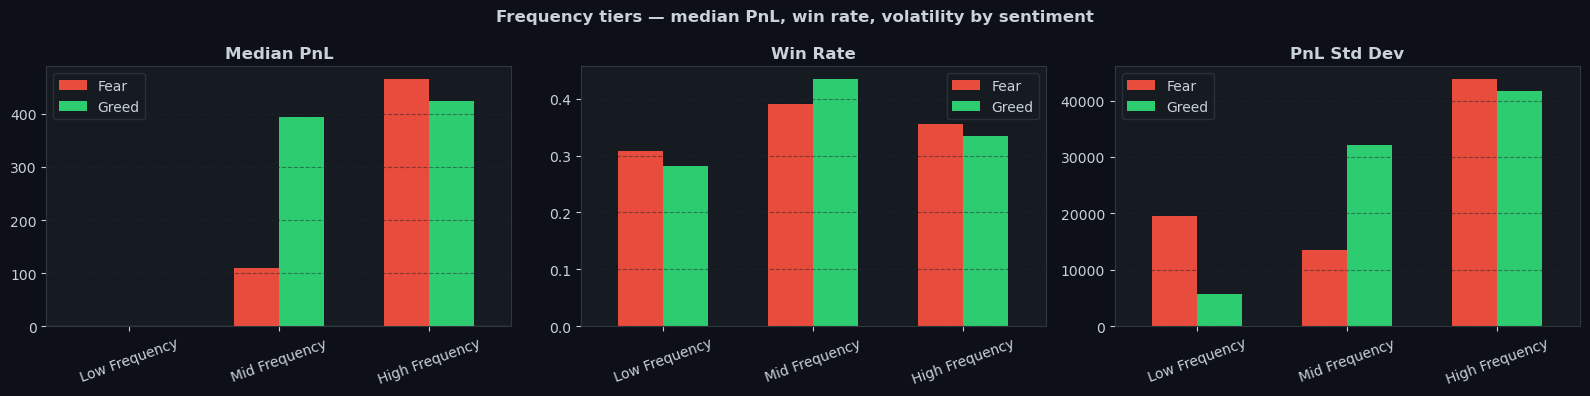

In [57]:
# frequency segment chart
seg_freq = td.groupby(['freq_tier','sentiment']).agg(
    median_pnl = ('daily_pnl', 'median'),
    win_rate   = ('win_rate',  'mean'),
    pnl_std    = ('daily_pnl', 'std'),
).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Frequency tiers — median PnL, win rate, volatility by sentiment',
             fontsize=12, fontweight='bold', color=TXT)

order_f = ['Low Frequency','Mid Frequency','High Frequency']
for ax, (col, label) in zip(axes, [('median_pnl','Median PnL'),
                                     ('win_rate','Win Rate'),
                                     ('pnl_std','PnL Std Dev')]):
    pivot = seg_freq.pivot(index='freq_tier', columns='sentiment', values=col).reindex(order_f)
    pivot.plot(kind='bar', ax=ax, color=[FEAR_C, GREED_C], edgecolor='none', width=0.6)
    ax.set_title(label, fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=20)
    ax.legend(title='')
    ax.grid(True, axis='y')
    if col == 'median_pnl':
        ax.axhline(0, color='white', lw=0.8)

plt.tight_layout()
plt.savefig('charts/chart4_frequency_segments.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()


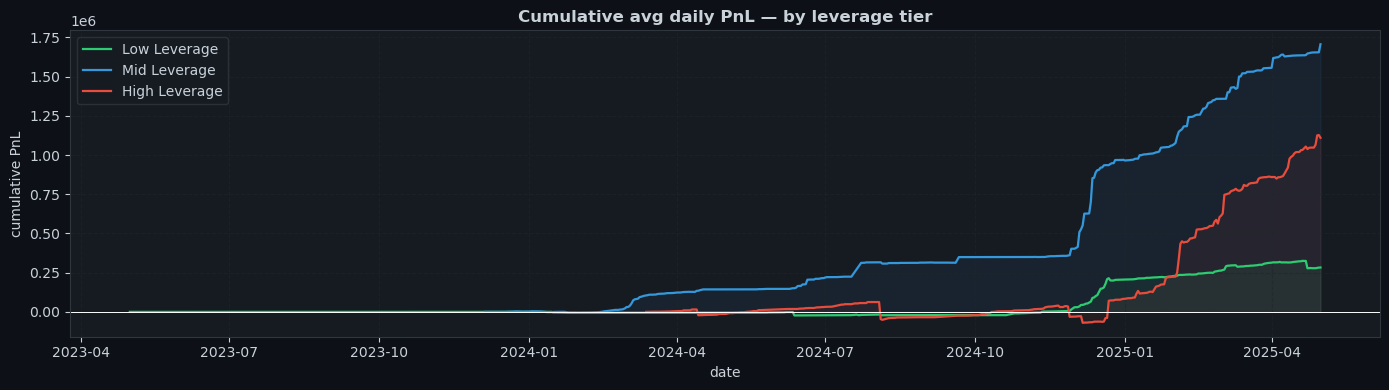

In [58]:
# cumulative PnL by leverage tier
daily_cum = (td.groupby(['date','lev_tier'])['daily_pnl']
             .mean().reset_index().sort_values('date'))
daily_cum['cum'] = daily_cum.groupby('lev_tier')['daily_pnl'].cumsum()

fig, ax = plt.subplots(figsize=(14, 4))
ax.set_title('Cumulative avg daily PnL — by leverage tier', fontweight='bold', color=TXT)

for tier, color in zip(order, [GREED_C, BASE_C, FEAR_C]):
    d = daily_cum[daily_cum['lev_tier']==tier]
    ax.plot(d['date'], d['cum'], color=color, lw=1.6, label=tier)
    ax.fill_between(d['date'], d['cum'], alpha=0.07, color=color)

ax.axhline(0, color='white', lw=0.7)
ax.set_xlabel('date'); ax.set_ylabel('cumulative PnL')
ax.legend(); ax.grid(True)
plt.tight_layout()
plt.savefig('charts/chart5_cumulative.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()


### Clustering traders into behavioral archetypes

         avg_leverage  trades_per_day  winrate  pnl_volatility    total_pnl  \
cluster                                                                       
0               6.472         124.223    0.351         878.589   187822.770   
1              25.187         158.533    0.400         542.726   390628.975   
2              11.936         108.317    0.348        3033.239  1871806.209   
3               3.629          79.873    0.504         466.572   214600.052   

         avg_trade_size  long_bias  
cluster                             
0              4574.642      0.498  
1             24666.436      0.520  
2              9998.731      0.452  
3              2043.479      0.388  


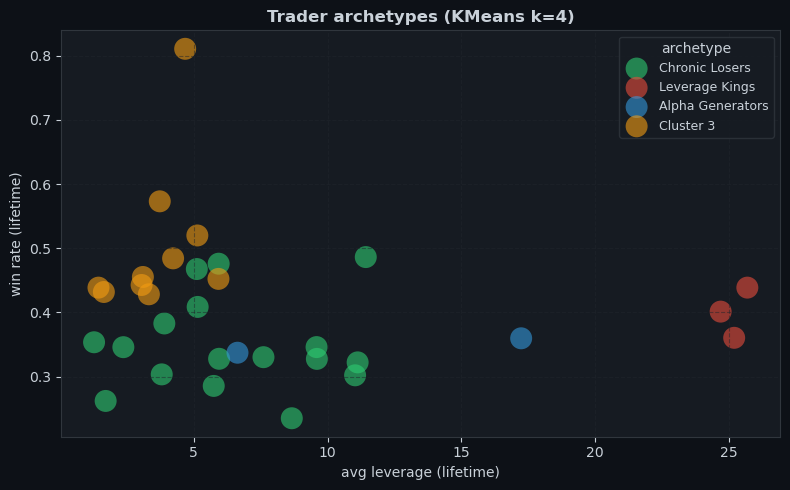

In [59]:
features = ['avg_leverage','trades_per_day','winrate','pnl_volatility',
            'total_pnl','avg_trade_size','long_bias']
prof = trader_profile.dropna(subset=features).copy()

scaler = StandardScaler()
X = scaler.fit_transform(prof[features])

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
prof['cluster'] = kmeans.fit_predict(X)

cluster_summary = prof.groupby('cluster')[features].mean().round(3)
print(cluster_summary)

archetype_map = {
    cluster_summary['total_pnl'].idxmax():      'Alpha Generators',
    cluster_summary['total_pnl'].idxmin():      'Chronic Losers',
    cluster_summary['trades_per_day'].idxmax(): 'Scalpers',
    cluster_summary['avg_leverage'].idxmax():   'Leverage Kings',
}
for c in range(4):
    if c not in archetype_map:
        archetype_map[c] = f'Cluster {c}'
prof['archetype'] = prof['cluster'].map(archetype_map)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Trader archetypes (KMeans k=4)', fontweight='bold', color=TXT)
palette = [GREED_C, FEAR_C, BASE_C, '#f39c12']
for c in range(4):
    sub = prof[prof['cluster']==c]
    ax.scatter(sub['avg_leverage'], sub['winrate'],
               s=np.clip(sub['trades_per_day']*25, 15, 250),
               c=palette[c], alpha=0.6, label=archetype_map[c], edgecolors='none')
ax.set_xlabel('avg leverage (lifetime)')
ax.set_ylabel('win rate (lifetime)')
ax.legend(title='archetype', fontsize=9)
ax.grid(True)
plt.tight_layout()
plt.savefig('charts/chart6_archetypes.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()


### Predicting next-day profitability bucket

Using a 3-class target: Top / Mid / Bottom. More realistic than binary.


In [60]:
# build features at trader×day level
model_df = td.sort_values(['account','date']).copy()
model_df['next_bucket'] = (model_df.groupby('account')['daily_pnl']
                            .shift(-1)
                            .apply(lambda x: 'Top' if x > model_df['daily_pnl'].quantile(0.67)
                                   else ('Bottom' if x < model_df['daily_pnl'].quantile(0.33)
                                         else 'Mid')))
model_df = model_df.dropna(subset=['next_bucket'])

features = ['is_greed','daily_pnl','n_trades','win_rate',
            'avg_leverage','long_ratio','trader_avg_lev','winrate','trades_per_day']

X = model_df[features].fillna(0)
y = model_df['next_bucket']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
clf = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      Bottom       0.08      0.02      0.03        51
         Mid       0.56      0.78      0.65       229
         Top       0.54      0.39      0.46       188

    accuracy                           0.54       468
   macro avg       0.39      0.40      0.38       468
weighted avg       0.50      0.54      0.51       468



### Predicting next-day PnL volatility

Volatility prediction MAE: 11827.30


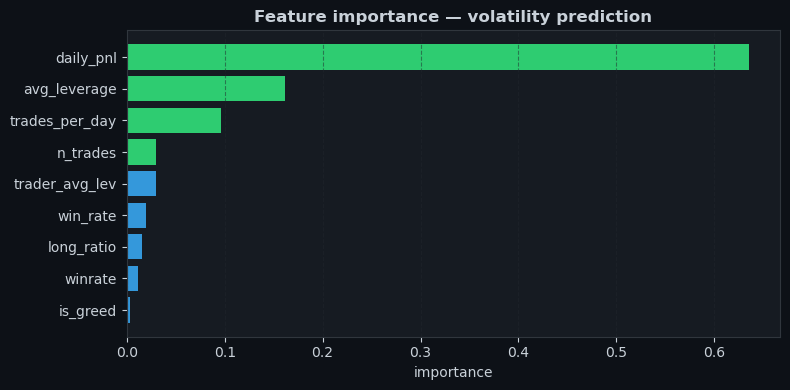

In [61]:
# regression: predict next-day pnl_std
vol_df = td.sort_values(['account','date']).copy()
vol_df['next_vol'] = vol_df.groupby('account')['daily_pnl'].transform(
    lambda x: x.rolling(3).std().shift(-1)
)
vol_df = vol_df.dropna(subset=['next_vol'])

X_v = vol_df[features].fillna(0)
y_v = vol_df['next_vol']

Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_v, y_v, test_size=0.2, shuffle=False)
reg = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
reg.fit(Xv_train, yv_train)
yv_pred = reg.predict(Xv_test)

print(f"Volatility prediction MAE: {mean_absolute_error(yv_test, yv_pred):.2f}")

feature_importance = pd.Series(reg.feature_importances_, index=features).sort_values()
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Feature importance — volatility prediction', fontweight='bold', color=TXT)
ax.barh(feature_importance.index, feature_importance.values,
        color=[GREED_C if v > feature_importance.median() else BASE_C
               for v in feature_importance.values],
        edgecolor='none')
ax.set_xlabel('importance')
ax.grid(True, axis='x')
plt.tight_layout()
plt.savefig('charts/chart7_feature_importance.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()


---
## Part C: Strategy Recommendations

---

### Strategy 1: Leverage Cap During Fear

**Condition:**
Fear days + High leverage traders (fixed segment based on lifetime avg leverage)

**Action:**
Cap leverage to the median leverage of the Low Leverage segment.

**Why:**
High leverage traders show notably higher PnL std dev on Fear days compared to Greed days.
Median PnL also drops. The effect is specific to this segment — low leverage traders
are largely unaffected by sentiment, so a blanket cap would be too broad.

---

### Strategy 2: Trade Frequency Guardrail During Fear

**Condition:**
Fear days + Low frequency traders (fixed segment based on lifetime trades/day)

**Action:**
Limit daily trades to the trader's own historical median.

**Why:**
Low frequency traders show declining win rate and higher volatility when they
trade above their usual pace on Fear days. Looks like they're reacting to
market noise rather than signal. High frequency traders don't show the same pattern,
so this only applies to this segment.


---
### Limitations

- Daily aggregation hides intra-day behavior — a trader who opens and closes 10 positions
  in an hour looks the same as one who spaces them out across the day.
- Leverage is a proxy derived from position size, not the actual leverage used.
  Real leverage data would sharpen the segmentation significantly.
- The volatility prediction model doesn't include market-wide variables like BTC realized vol
  or funding rates, which are probably strong predictors.
- Binary Fear/Greed classification loses the nuance of Extreme Fear vs mild Fear —
  those may behave quite differently.
- Profitability bucket prediction is simplistic — a continuous PnL prediction
  would be more useful in practice.
